In [1]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
from scipy import stats
import matplotlib.pyplot as plt

# Homework 6: Part I

1. Go get data from kaggle.com and do a ***(Univariate) Bayesian Logistic Regression*** analysis

2. Adjust the code below to specify that the outcomes have a Bernoulli distribution and use a ***logit*** or ***probit link function*** (or $\Pr(z\leq 0)$ for latent $z$ ) to correctly paramterize the predicted values of the observed outcomes

```python
import pymc as pm; import numpy as np
n,p=100,10; X,y=np.zeros((n,p)),np.ones((n,1))
# Replace this made up data with your data set from kaggle...
with pm.Model() as MLR:
    betas = pm.MvNormal('betas', mu=np.zeros((p,1)), cov=np.eye(p), shape=(p,1))
    sigma = pm.TruncatedNormal('sigma', mu=1, sigma=1, lower=0) # half normal
    y = pm.Normal('y', mu=pm.math.dot(X, betas), sigma=sigma, observed=y)

with MLR:
    idata = pm.sample()
```    

3. Choose ***prior*** that are sensible for your specification

4. [Optional] Assess the performance of the MCMC and any issues or warnings in the [standard manner](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#pymc-overview)

4. [Optional] Go get data from kaggle.com and do a ***Multivariate Bayesian Logistic Regression*** analysis


In [2]:
# Step 1: Recategorize outcome data ("Good", "Bad") to (1, 0)

df = pd.read_csv("https://raw.githubusercontent.com/ray0130/STA365/main/HW6/banana_quality.csv")

# Reformat outcome variable
df["Quality"] = df["Quality"].replace({'Good': 1, 'Bad': 0})

X = df[["Size", "Weight", "Sweetness", "Softness", "HarvestTime", "Ripeness", "Acidity"]].values

y = df[["Quality"]].values.reshape(-1, 1)

# print(y)


In [7]:

# n,p=100,10

n, p = X.shape

# Replace this made up data with your data set from kaggle...
with pm.Model() as MLR:
    # I am using MvNormal because I think some attributes may have correlation, such as Size ~ Weight, Sweeetness ~ Acidity, HarvestTime ~ Ripeness
    # MvNormal is also sensible because from the kaggle website of the data: https://www.kaggle.com/datasets/l3llff/banana
    # each attributes also seem to follow a normal distribution
    betas = pm.MvNormal('betas', mu=np.zeros((p,1)), cov=np.eye(p), shape=(p,1))
    sigma = pm.TruncatedNormal('sigma', mu=1, sigma=1, lower=0) # half normal

    # Apply logit
    # p = pm.logit(pm.math.dot(X, betas))
    y_obs = pm.Bernoulli('y_obs', logit_p=pm.math.dot(X, betas), observed=y)

with MLR:
    idata = pm.sample()

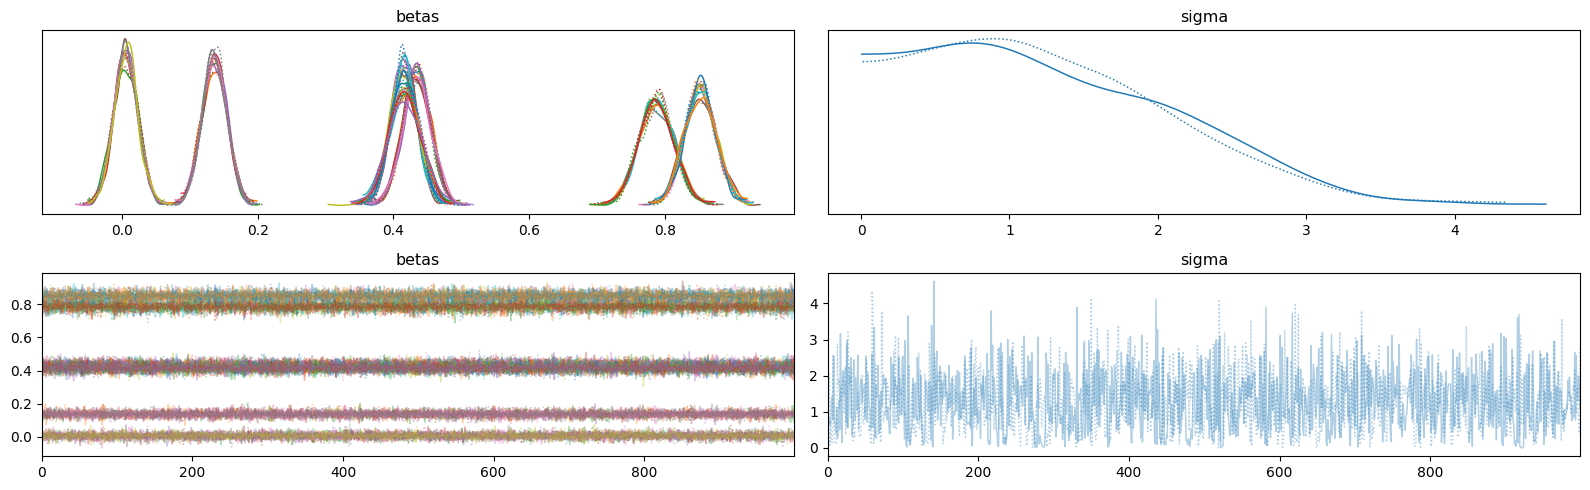

In [9]:
# Optional Step 4, analysis

fig,ax = plt.subplots(2,2,figsize=(16,5))
az.plot_trace(idata, var_names=["betas", "sigma"], axes=ax.T)
plt.tight_layout();

# Homework 6: Part II<br>Regularized Loss Functions

***Machine Learning*** fits models by optimizing penalized ***loss functions***

Two classic regularizations are "ridge" and "lasso" regression, which respectively use $L_2$ and $L_1$ penalty functions

- Lasso: $$\sum_{i=1}^n \frac{1}{2}(y_i-x_i^T\beta_{p \times 1})^2 + \lambda \sum_{j=1}^n \beta_j^2 = \frac{1}{2}(y-X\beta)^T(y-X\beta) + \lambda \sum_{j=1}^n \beta_j^2 = \frac{1}{2}||y-X\beta||_2^2 + \lambda ||\beta||_2^2 $$
- Ridge: $$\sum_{i=1}^n \frac{1}{2}(y-x_i^T\beta_{p \times 1})^2 + \lambda \sum_{j=1}^n |\beta_j| = \frac{1}{2}(y-X\beta)^T(y-X\beta) + \lambda \sum_{j=1}^n |\beta_j| = \frac{1}{2}||y-X\beta||_2^2 + \lambda ||\beta||_1$$
    
Show that for $\sigma=1$ and ***hyperparameters*** $b_i=0$ (ignoring normalizing proportionality constants) the log posterior distributions for $\beta$ using either ***normal*** or ***Laplace*** prior distributions have analagous forms to the above expressions

Now write down and understand the following: "Bayesians do not optimize posterior distributions, they sample from them; but, the posterior distributions are nonetheless 'regularizations' of the likelihood through the prior."

Lasso:

\begin{align*}
    Likelihood: y &= \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{1}{2}(\frac{y - X\beta}{\sigma})^2}\\
    Normal Prior: \beta &= \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{1}{2}(\frac{\beta - b}{s})^2} \\
    Laplace Prior: \beta &= \frac{1}{2b} exp(-\frac{|\beta - b|}{s})
\end{align*}

Lasso:
\begin{align*}
    Likelihood \times Normal Prior &\propto Posterior\\
    Posterior &\propto \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{1}{2}(\frac{y - X\beta}{\sigma})^2} \cdot \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{1}{2}(\frac{\beta - b}{s})^2}\\
    &=\frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}(\frac{y - X\beta}{1})^2} \cdot \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}(\frac{\beta - 0}{s})^2}\\
    &\propto  e^{-\frac{1}{2}(y - X\beta)^2} \cdot e^{-\frac{1}{2}(\beta)^2}\\
    Log Posterior &= log(e^{-\frac{1}{2}(y - X\beta)^2} \cdot e^{-\frac{1}{2}(\frac{\beta}{s})^2})\\
    &= -\frac{1}{2}(y - X\beta)^2 + -\frac{1}{2}(\frac{\beta}{s})^2 \\
    &\propto \frac{1}{2}(y - X\beta)^2 + \frac{1}{2s^2}(\beta)^2 \\
    &= \frac{1}{2} || y - X\beta ||^2_2 + \lambda ||\beta||^2_2 \tag{$\lambda = \frac{1}{2s^2}$}
\end{align*}

Ridge:
\begin{align*}
    Likelihood \times Laplace Prior &\propto Posterior\\
    Posterior &\propto \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{1}{2}(\frac{y - X\beta}{\sigma})^2} \cdot \frac{1}{2b} exp(-\frac{|\beta - b|}{s})\\
    &\propto e^{-\frac{1}{2}(\frac{y - X\beta}{\sigma})^2} \cdot exp(-\frac{|\beta - b|}{s})\\
    &= e^{-\frac{1}{2}(\frac{y - X\beta}{1})^2} \cdot exp(-\frac{|\beta - 0|}{s})\\
    &= e^{-\frac{1}{2}(y - X\beta)^2} \cdot exp(-\frac{|\beta|}{s})\\
    Log Posterior &= log(e^{-\frac{1}{2}(y - X\beta)^2} \cdot exp(-\frac{|\beta|}{s}))\\
    &= -\frac{1}{2}(y - X\beta)^2 + -(\frac{\beta}{s}) \\
    &\propto \frac{1}{2}(y - X\beta)^2 + \frac{1}{s}(\beta) \\
    &= \frac{1}{2} || y - X\beta ||^2_2 + \lambda ||\beta||_1 \tag{$\lambda = \frac{1}{s}$}
\end{align*}

Ray Understands:

Bayesians do not optimize posterior distributions, they sample from them; but, the posterior distribution are nonetheless 'regularizations' of the likelihood through the prior.
